In [1]:
# import required libraries
  
import librosa                     # librosa music package
import IPython                     # for playing audio
import numpy as np                 # for handling large arrays
import pandas as pd                # for data manipulation and analysis
import scipy                       # for common math functions
import os                          # for accessing local files

import librosa.display             # librosa plot functions
import matplotlib.pyplot as plt    # plotting with Matlab functionality
import seaborn as sns              # data visualization based on matplotlib
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

In [35]:
# declare constants

# audio loading
SAMPLE_RATE = 16000
FRAME_LENGTH = 512
HOP_LENGTH = 256
N_FFT = 2048

# file paths
ROOT_CSV_PATH = 'data/virufy_cdf_coughvid.csv'
ROOT_DIR_PATH = 'data/wav/'
ROOT_DIR_PATH_PROCESSED = 'data/wav_processed/'

In [36]:
coughvid_df_raw = pd.read_csv(ROOT_CSV_PATH)

# filter cough with 0.7 threshold - this means audio is 70% likely to be a cough
mask = (coughvid_df_raw.loc[:,'cough_detected'] > 0.7)
coughvid_df_cough = coughvid_df_raw.loc[mask,:]

# filter out untested results from clinically inferred PCR test results
mask = (coughvid_df_cough.loc[:,'pcr_test_result_inferred'] == 'untested')
coughvid_df = coughvid_df_cough.loc[~mask,:]

coughvid_df.sample(5)

,Unnamed: 0,source,patient_id,cough_detected,cough_path,age,biological_sex,reported_gender,submission_date,pcr_test_date,pcr_result_date,respiratory_condition,fever_or_muscle_pain,pcr_test_result,pcr_test_result_inferred,covid_symptoms
5273,5273,coughvid,3fbfea7c-0807-4513-a564-dc0c4282eefb,0.8004,data/wav/3fbfea7c-0807-4513-a564-dc0c4282eefb.wav,60.0,male,male,2020-04-15T21:06:53.384745+00:00,NaN,NaN,False,False,untested,negative,False
17518,17518,coughvid,3d852a1b-e5a3-48d7-aff7-16e4d958bea0,0.8430,data/wav/3d852a1b-e5a3-48d7-aff7-16e4d958bea0.wav,38.0,male,male,2020-08-28T07:14:06.932870+00:00,NaN,NaN,False,False,untested,negative,False
7788,7788,coughvid,69d2f7b5-0557-41b0-91f5-016acdce89fb,0.9798,data/wav/69d2f7b5-0557-41b0-91f5-016acdce89fb.wav,45.0,male,male,2020-10-30T20:00:48.557761+00:00,NaN,NaN,False,False,untested,negative,False
13478,13478,coughvid,bf67cf82-7d3d-4ac4-b86e-43f8a29a96e8,0.8568,data/wav/bf67cf82-7d3d-4ac4-b86e-43f8a29a96e8.wav,NaN,female,female,2020-04-13T18:30:37.361076+00:00,NaN,NaN,False,False,untested,negative,False
13101,13101,coughvid,fbf957b5-2dbe-449d-bbeb-471cab9e360d,0.9557,data/wav/fbf957b5-2dbe-449d-bbeb-471cab9e360d.wav,36.0,male,male,2020-04-19T04:46:34.243150+00:00,NaN,NaN,False,False,untested,negative,False


In [71]:
coughvid_df_paths = coughvid_df['cough_path']
cough_filenames = coughvid_df_paths.values.tolist()

cough_filenames

['data/wav/68d5215b-afdb-4b7a-81d3-fbd5677de7b4.wav',
 'data/wav/3449851d-799e-404e-b143-58e852332948.wav',
 'data/wav/0c35e382-31cd-42cb-bc87-8a84b9c52a41.wav',
 'data/wav/cdd18865-400a-448e-902b-c8b53644a1c8.wav',
 'data/wav/0e35f667-974e-4ffc-b596-1b9a94793d1b.wav',
 'data/wav/52e79345-7280-4d22-9586-6214f5e3b95f.wav',
 'data/wav/d94d9646-3aa9-4ee7-9924-3c901fecf103.wav',
 'data/wav/4d59fd9a-236d-45ea-8b4d-bb9fe9857f8a.wav',
 'data/wav/73cbea4e-1884-4294-ba75-e2de6a8db118.wav',
 'data/wav/f8e542cd-28a5-484d-98aa-7249469ce78a.wav',
 'data/wav/069e6694-eadb-4864-82fe-532c07d22bc6.wav',
 'data/wav/95506d1a-d88f-4e15-87ad-f67ffb5471d5.wav',
 'data/wav/bab03040-f63f-410c-a3d4-8b2bf194fa50.wav',
 'data/wav/5e5ed149-7ce2-42dd-a599-6747f66c3d84.wav',
 'data/wav/1227b27b-6873-475d-8d44-3b7853245330.wav',
 'data/wav/87bdaf4c-d5db-4c92-a606-7c0b0eacb8c0.wav',
 'data/wav/e6ba12b4-ffd4-4dab-9f5c-e0c5d042c5d3.wav',
 'data/wav/ef481aa4-a9e4-490f-a47c-a0345613daf9.wav',
 'data/wav/e5903306-55ab-4d3

In [66]:
from tqdm.notebook import tqdm
import math

def generate_waveforms(sample_filenames):
    '''
    This is a helper function that plots waveform graphs (amplitude across time) of each sample.
    Parameters:
        sample_filenames: Array of original sample filenames
    '''
    
    ncols = 5
    nrows = math.ceil(len(sample_filenames)/ncols)
    fig_height = 2.5*nrows

    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=(15, fig_height))

    for i, filename in enumerate(tqdm(sample_filenames, desc='Generating waveforms')):

        # [0] because sample is loaded as a tuple
        sample = librosa.load(filename, SAMPLE_RATE, mono=True)[0]

        # remove file path and filetype
        sample_name_split = filename.split('/')[-1].split('.')[0]
        sample_name = 'Sample ' + sample_name_split.split('-')[0]
        
        cur_col = math.floor(i/ncols)
        cur_row = i%(ncols)

        librosa.display.waveplot(sample, sr=SAMPLE_RATE, ax=axs[cur_col, cur_row], color='b')
        axs[cur_col, cur_row].title.set_text(sample_name)

    plt.tight_layout()

Generating waveforms:   0%|          | 0/20 [00:00<?, ?it/s]

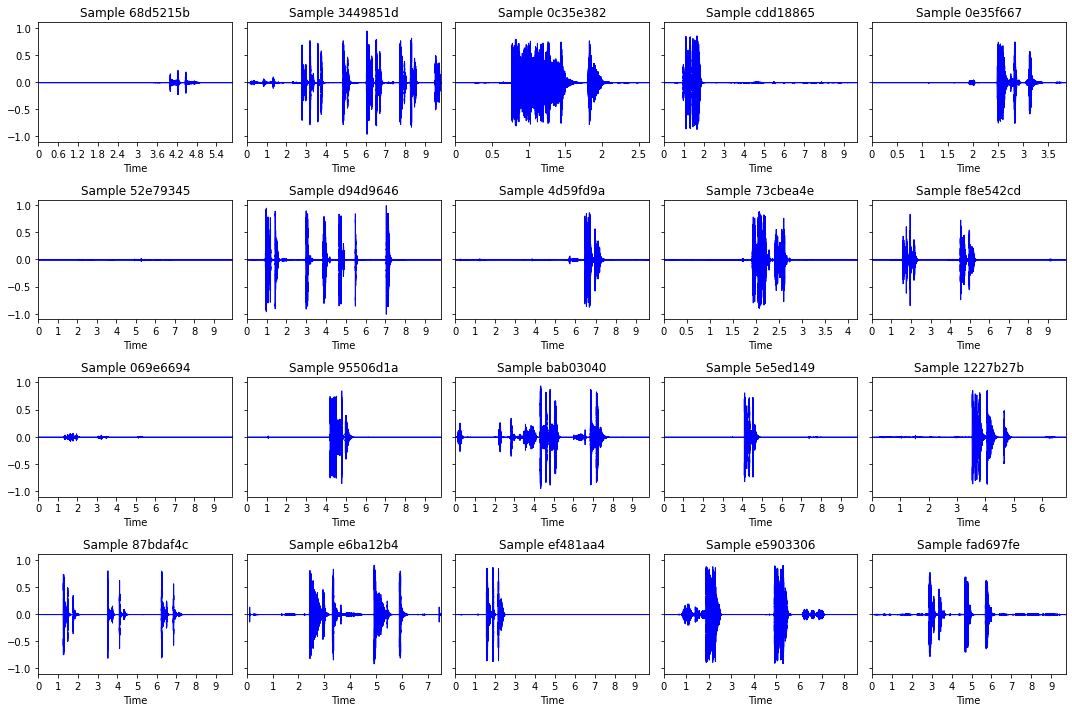

In [67]:
generate_waveforms(cough_filenames[:20])

In [68]:
def display_spectrogram(filename):

    # [0] because sample is loaded as a tuple
    sample = librosa.load(filename, SAMPLE_RATE)[0]
    
    # remove file path and filetype
    sample_name_split = filename.split('/')[-1].split('.')[0]
    sample_name = 'Sample ' + sample_name_split.split('-')[0]

    x = librosa.stft(sample, n_fft=N_FFT, hop_length=HOP_LENGTH)
    sample = librosa.amplitude_to_db(abs(x))
    
    plt.figure(figsize=(15, 5))
    librosa.display.specshow(sample, sr=SAMPLE_RATE, hop_length=HOP_LENGTH, 
                         x_axis='time', y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title(sample_name)

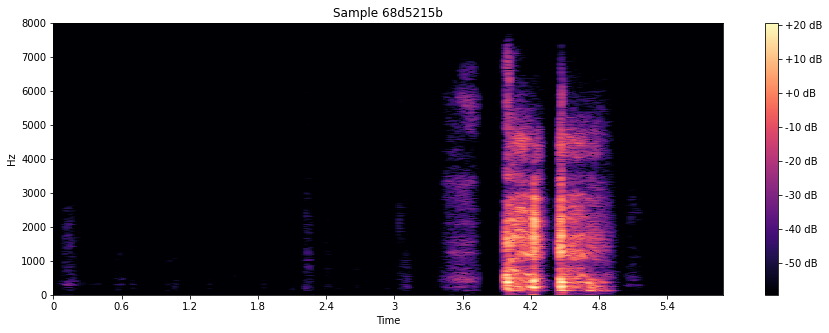

In [70]:
display_spectrogram(cough_filenames[0])

In [66]:
# coughvid_df_paths = coughvid_df['cough_path']
# filenames_train, filenames_val, filenames_test = np.split(coughvid_df_paths.sample(frac=1), [int(.6*len(coughvid_df_paths)), int(.8*len(coughvid_df_paths))])

# filenames_train.shape, filenames_val.shape, filenames_test.shape